# Project 1 - Quora Duplicates. Author - Lovnesh Bhardwaj

## Importing the Libraries
Here I am importing some of the libraries that will be used for the task at hand. I use a multitude of libraries.
Some of which are not introduced in the lab lectures that were shown in the class. 
Those packages are nltk and sklearn. Note: when you first run this code, and don't have nltk installed, please pip install it into your environment, 
and also nltk.download("stopwords"), nltk.download('punkt'), nltk.download('wordnet') which will be used to train the classifier.

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

## Defining Variables
Here I define some of the variables that will be used during the rest of the notebook

In [55]:
training_data_path = '../quora-question-data/train.csv'
test_data_path = '../quora-question-data/test.csv'
plots_path = '../plots'
SEED = 42

The cell below will read the data into a variable that will be used throughout

In [56]:
train_data = pd.read_csv(training_data_path)
test_data = pd.read_csv(test_data_path)

In [57]:
train_data

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
...,...,...,...,...,...,...
404285,404285,433578,379845,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0
404286,404286,18840,155606,Do you believe there is life after death?,Is it true that there is life after death?,1
404287,404287,537928,537929,What is one coin?,What's this coin?,0
404288,404288,537930,537931,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0


# Plots for Exploratory Data Analysis
To conduct some exploratory data analysis, we plot some plots:
The one below is the one which plots the difference in the number of the duplicates vs the non-duplicates

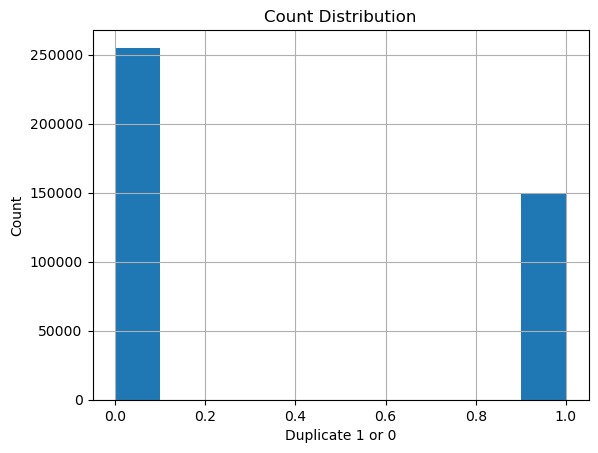

In [58]:
train_data.hist(column=["is_duplicate"])
plt.title("Count Distribution")
plt.xlabel("Duplicate 1 or 0")
plt.ylabel("Count")
plt.savefig(os.path.join(plots_path, "dupvsnondup_count.png"), format="png")
plt.show()

# Making new columns 
The next few cells make a columns which define the length of the question in columns 'question_1' and 'question_2' and also calculating the difference between the lengths of each.

In [59]:
train_data["question1"]= train_data["question1"].astype(str)
train_data["question2"] = train_data["question2"].astype(str)

In [60]:
# Calculating the length of the sentence in each of the columns.

train_data["len_q1"] = train_data["question1"].apply(lambda sentence: len(sentence.split()))
train_data["len_q2"] = train_data["question2"].apply(lambda sentence: len(sentence.split()))

In [61]:
train_data["length_difference"] = np.abs(train_data["len_q1"] - train_data["len_q2"])

# Plots
Here we plot the distribution of the lengths, and their differences.

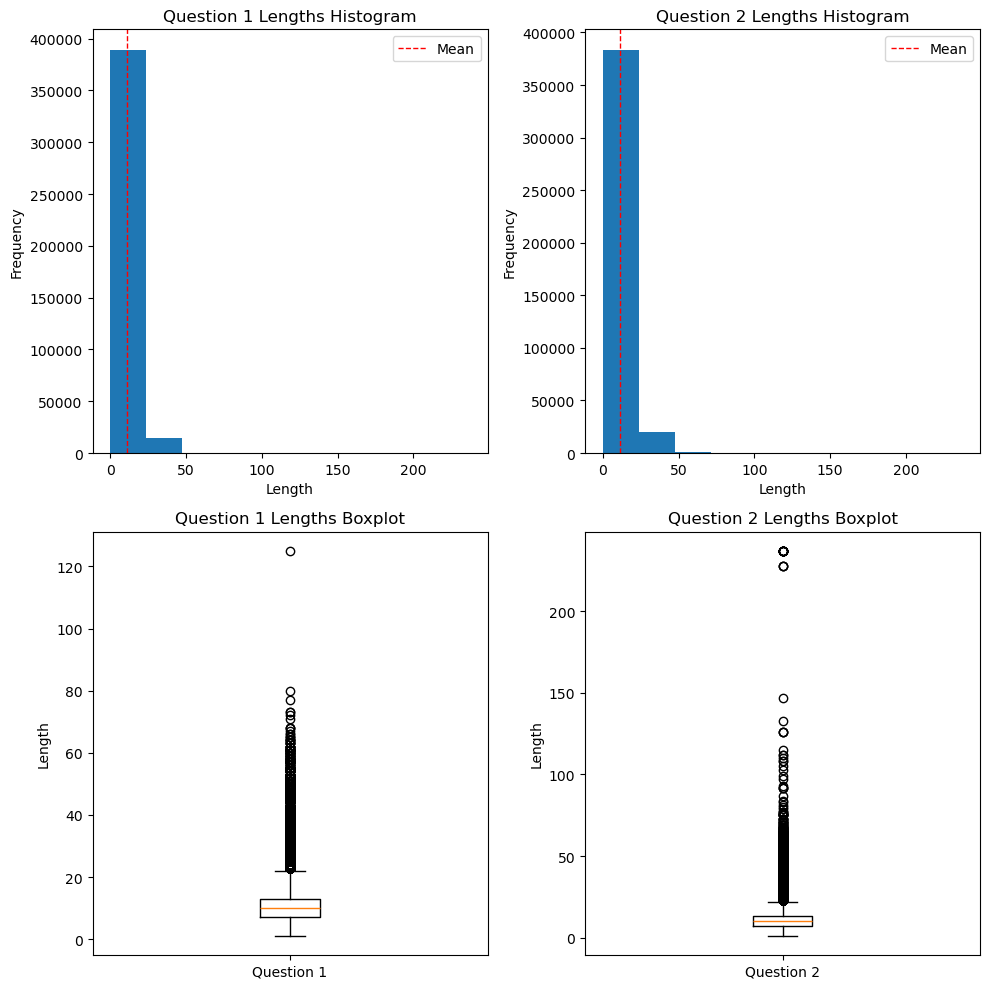

In [62]:
x_min = min(train_data[['len_q1', 'len_q2']].values.min(), 0)
x_max = train_data[['len_q1', 'len_q2']].values.max()

# Create a 2x2 subplot grid
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

# Plot histograms
axes[0, 0].hist(train_data['len_q1'], range=(x_min, x_max))
axes[0, 0].axvline(np.mean(train_data["len_q1"]), color='r', linestyle='dashed', linewidth=1)
axes[0, 0].legend(["Mean"])
axes[0, 0].set_title('Question 1 Lengths Histogram')
axes[0, 0].set_xlabel('Length')
axes[0, 0].set_ylabel('Frequency')

axes[0, 1].hist(train_data['len_q2'], range=(x_min, x_max))
axes[0, 1].axvline(np.mean(train_data["len_q2"]), color='r', linestyle='dashed', linewidth=1)
axes[0, 1].legend(["Mean"])
axes[0, 1].set_title('Question 2 Lengths Histogram')
axes[0, 1].set_xlabel('Length')
axes[0, 1].set_ylabel('Frequency')

# Plot box plots
axes[1, 0].boxplot([train_data['len_q1']], labels=['Question 1'])
axes[1, 0].set_title('Question 1 Lengths Boxplot')
axes[1, 0].set_ylabel('Length')

axes[1, 1].boxplot([train_data['len_q2']], labels=['Question 2'])
axes[1, 1].set_title('Question 2 Lengths Boxplot')
axes[1, 1].set_ylabel('Length')

plt.tight_layout()
plt.savefig(os.path.join(plots_path, 'lengths_comp.png'), format='png')
plt.show()

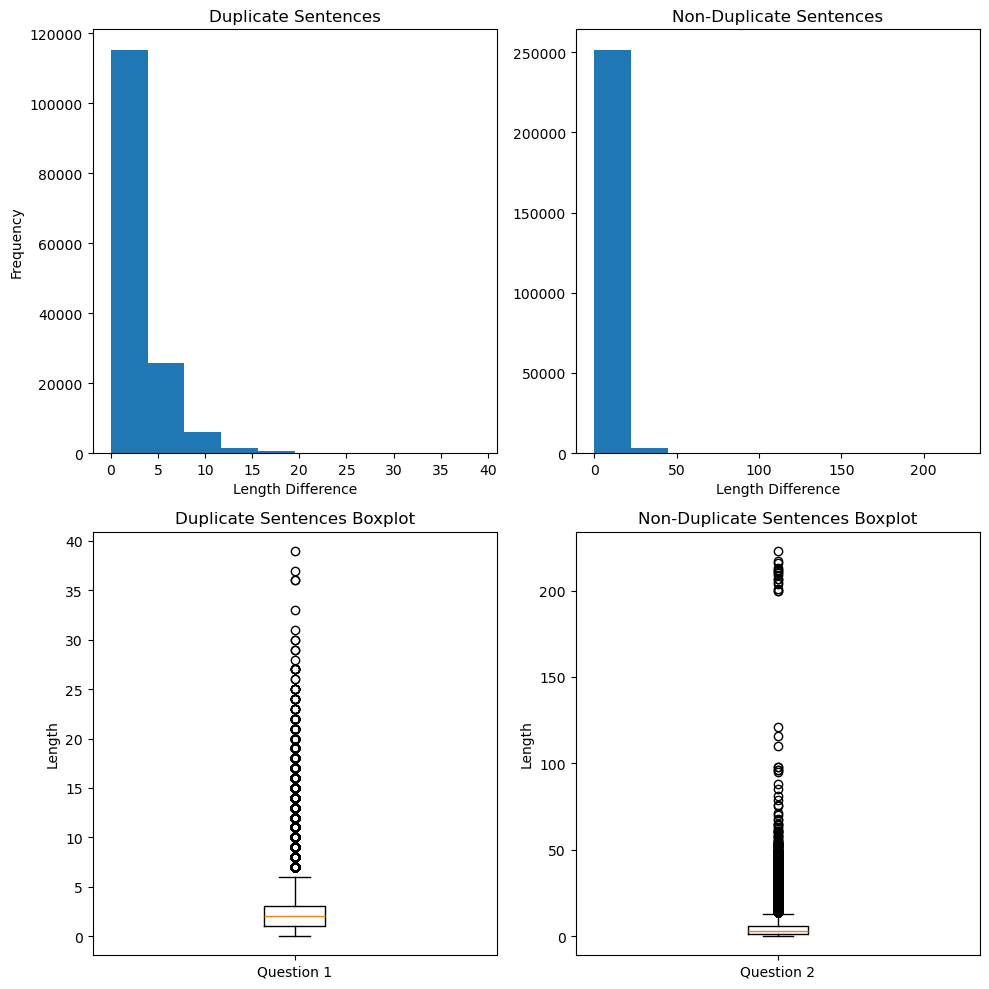

In [63]:
duplicates = train_data.query('is_duplicate == 1')
not_duplicates = train_data.query('is_duplicate == 0')

_, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

# Plot histograms
axes[0, 0].hist(duplicates["length_difference"])
axes[0, 0].set_title('Duplicate Sentences')
axes[0, 0].set_xlabel('Length Difference')
axes[0, 0].set_ylabel('Frequency')

axes[0, 1].hist(not_duplicates["length_difference"])
axes[0, 1].set_title('Non-Duplicate Sentences')
axes[0, 1].set_xlabel('Length Difference')
axes[0, 0].set_ylabel('Frequency')

# Plot box plots
axes[1, 0].boxplot([duplicates["length_difference"]], labels=['Question 1'])
axes[1, 0].set_title('Duplicate Sentences Boxplot')
axes[1, 0].set_ylabel('Length')

axes[1, 1].boxplot([not_duplicates["length_difference"]], labels=['Question 2'])
axes[1, 1].set_title('Non-Duplicate Sentences Boxplot')
axes[1, 1].set_ylabel('Length')

plt.tight_layout()
plt.savefig(os.path.join(plots_path, 'dup_vs_non_dup.png'), format='png')
plt.show()

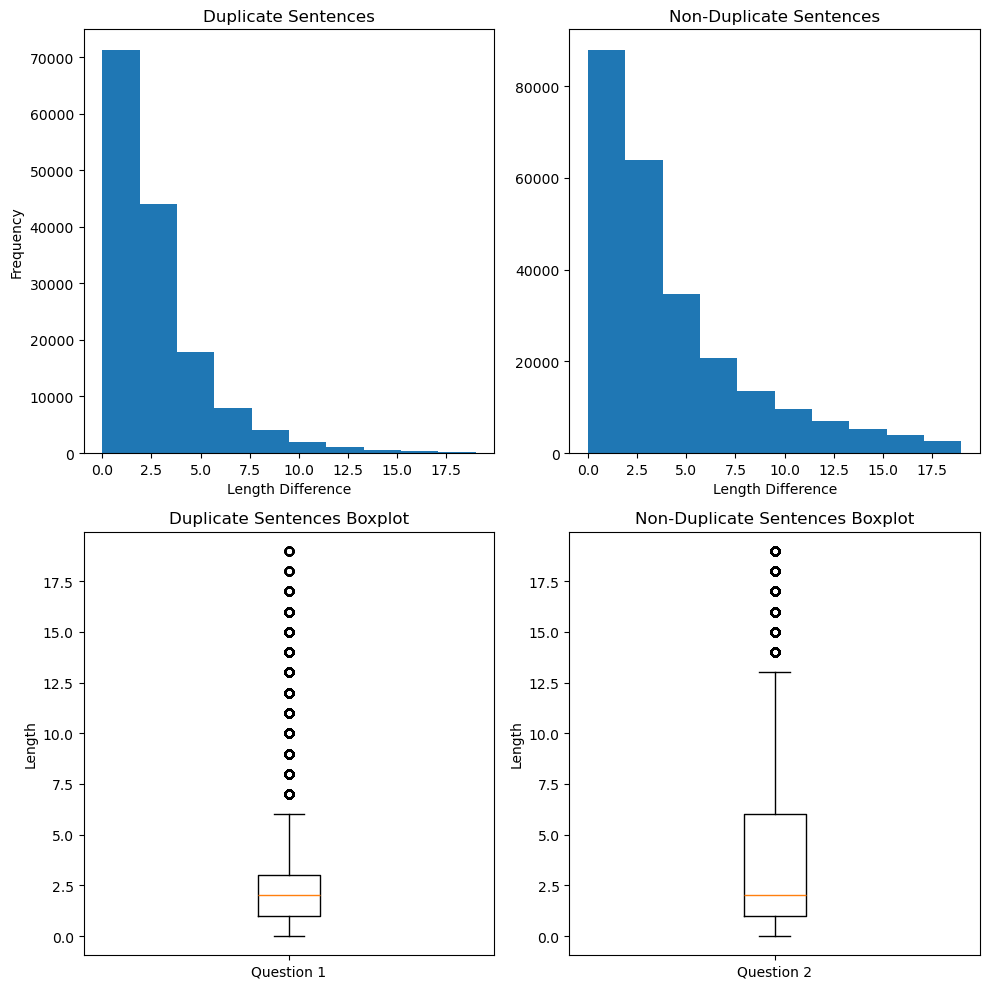

In [64]:
# Closer look at the non-duplicate lengths after filtering out lengths > 20
_, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

# Plot histograms
axes[0, 0].hist(duplicates[duplicates["length_difference"] < 20]["length_difference"])
axes[0, 0].set_title('Duplicate Sentences')
axes[0, 0].set_xlabel('Length Difference')
axes[0, 0].set_ylabel('Frequency')

axes[0, 1].hist(not_duplicates[not_duplicates["length_difference"] < 20]["length_difference"])
axes[0, 1].set_title('Non-Duplicate Sentences')
axes[0, 1].set_xlabel('Length Difference')
axes[0, 0].set_ylabel('Frequency')

# Plot box plots
axes[1, 0].boxplot([duplicates[duplicates["length_difference"] < 20]["length_difference"]], labels=['Question 1'])
axes[1, 0].set_title('Duplicate Sentences Boxplot')
axes[1, 0].set_ylabel('Length')

axes[1, 1].boxplot([not_duplicates[not_duplicates["length_difference"] < 20]["length_difference"]], labels=['Question 2'])
axes[1, 1].set_title('Non-Duplicate Sentences Boxplot')
axes[1, 1].set_ylabel('Length')

plt.tight_layout()
plt.savefig(os.path.join(plots_path, 'focus_dupvsnondup.png'), format='png')
plt.show()

# Training a model
Training the model requires the pre-processing of the data so that making it a feature is easier. To do so, 
we used the concept of stop-word removal and stemming. Stop-word removal refers to the removal of the words that 
are used a lot in the english language such as 'a', 'the', 'that', etc. And the process of stemming refers to the
process of putting the word in its base stem. For example, 'runs' would become 'run', 'clapped' would become 'clap'.

In [65]:
# Preprocess the sentences
lemmatizer = WordNetLemmatizer() # Stemmer
stop_words = set(stopwords.words('english'))    # Stop words

# The function below takes a sentences, which is a question, and removes the stopwords, and applies the stemming algorithm.
def preprocess_sentence(sentence):
    tokens = word_tokenize(sentence.lower())
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token.isalnum() and token not in stop_words]
    return ' '.join(tokens)

# Preprocess sentences in DataFrame
train_data['preprocessed_question_1'] = train_data['question1'].apply(preprocess_sentence)
train_data['preprocessed_question_2'] = train_data['question2'].apply(preprocess_sentence)

# Jaccard Similarity
After the removal of stopwords and stemming the sentences, we calculate the similarity between them both. This is done using Jaccard Similarity 
measure which is a good tool, and at the word level, it also captures the syntactic meaning of the word somewhat.


In [66]:
# Compute Jaccard similarity
def jaccard_similarity(s1, s2):
    set1 = set(s1.split())
    set2 = set(s2.split())
    intersection = len(set1 & set2)
    union = max(len(set1 | set2), 1)    # To prevent division by 0
    return intersection / union

train_data['jaccard_similarity'] = train_data.apply(lambda row: jaccard_similarity(row['preprocessed_question_1'], row['preprocessed_question_2']), axis=1)


# TF-IDF
We then calculate the TF-IDF of the questions which just calculates the term frequencies and gives importance to the rare occuring words

In [67]:
vectorizer = TfidfVectorizer()
X_syntactic = vectorizer.fit_transform(train_data['preprocessed_question_1'] + ' ' + train_data['preprocessed_question_2'])

# Composing a Feature Vector
Putting all the data that is given above is as follows:
We make the feature vector a composition of the difference of length, the jaccard similarity and the TF_IDF of the sentences, and then 
we stack them together. We use the function 'hstack' which works on sparse matrices, as using the numpy version of the same would result in a memory overflow 

In [68]:
from scipy.sparse import hstack

X_combined = hstack((train_data['length_difference'].values.reshape(-1, 1), train_data['jaccard_similarity'].values.reshape(-1, 1), X_syntactic))
y = train_data['is_duplicate'].values

# Model Prediction

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=SEED)
# Train a classifier
classifier = LogisticRegression(max_iter=3000)
classifier.fit(X_train, y_train)

# Evaluate the classifier
y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7861683445051819


In [70]:
def preprocess_duplicates(dataframe: pd.DataFrame):
    dataframe["question1"]= dataframe["question1"].astype(str)
    dataframe["question2"] = dataframe["question2"].astype(str)
    dataframe["len_q1"] = dataframe["question1"].apply(lambda sentence: len(sentence.split()))
    dataframe["len_q2"] = dataframe["question2"].apply(lambda sentence: len(sentence.split()))
    dataframe["length_difference"] = np.abs(dataframe["len_q1"] - dataframe["len_q2"])
    dataframe["preprocessed_question_1"]= dataframe["question1"].apply(preprocess_sentence)
    dataframe["preprocessed_question_2"]= dataframe["question2"].apply(preprocess_sentence)
    dataframe['jaccard_similarity'] = dataframe.apply(lambda row: jaccard_similarity(row['preprocessed_question_1'], row['preprocessed_question_2']), axis=1)
    new_syntactic_features = vectorizer.transform(dataframe['preprocessed_question_1'] + ' ' + dataframe['preprocessed_question_2'])
    return hstack((dataframe['length_difference'].values.reshape(-1, 1), dataframe['jaccard_similarity'].values.reshape(-1, 1), new_syntactic_features))

In [71]:
X_combined_new = preprocess_duplicates(test_data)
y_predicted = classifier.predict(X_combined_new)
test_data["predicted_duplicates"] = y_predicted


In [72]:
test_data  # Predicted duplicates column gives if they are duplicates or not.

,test_id,question1,question2,len_q1,len_q2,length_difference,preprocessed_question_1,preprocessed_question_2,jaccard_similarity,predicted_duplicates
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...,11,14,3,surface pro 4 compare ipad pro,microsoft choose core m3 core i3 home surface ...,0.272727,0
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?,14,7,7,hair transplant age 24 much would cost,much cost hair transplant require,0.500000,0
2,2,What but is the best way to send money from Ch...,What you send money to China?,14,6,8,best way send money china u,send money china,0.500000,0
3,3,Which food not emulsifiers?,What foods fibre?,4,3,1,food emulsifier,food fibre,0.333333,0
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?,4,6,2,aberystwyth start reading,start reading,0.666667,1
...,...,...,...,...,...,...,...,...,...,...
2345791,2345791,How do Peaks (TV series): Why did Leland kill ...,What is the most study scene in twin peaks?,11,9,2,peak tv series leland kill laura palmer,study scene twin peak,0.100000,0
2345792,2345792,"What does be ""in transit"" mean on FedEx tracking?",How question FedEx packages delivered?,9,5,4,transit mean fedex tracking,question fedex package delivered,0.142857,0
2345793,2345793,What are some famous Romanian drinks (alcoholi...,Can a non-alcoholic restaurant be a huge success?,9,8,1,famous romanian drink alcoholic,restaurant huge success,0.000000,0
2345794,2345794,What were the best and worst things about publ...,What are the best and worst things examination...,20,20,0,best worst thing public transit proddatur andh...,best worst thing examination public transit vi...,0.769231,0
